## In this file we will use the KeplerMapper python class with a one-variable filter

Installing the class

In [2]:
from __future__ import division
import numpy as np
from collections import defaultdict
import json
import itertools
from sklearn import cluster, preprocessing, manifold
from datetime import datetime
import sys

class KeplerMapper(object):
  # With this class you can build topological networks from (high-dimensional) data.
  #
  # 1)   	Fit a projection/lens/function to a dataset and transform it. 
  #     	For instance "mean_of_row(x) for x in X"
  # 2)   	Map this projection with overlapping intervals/hypercubes. 
  #    		Cluster the points inside the interval 
  #    		(Note: we cluster on the inverse image/original data to lessen projection loss).
  #    		If two clusters/nodes have the same members (due to the overlap), then: 
  #    		connect these with an edge.
  # 3)  	Visualize the network using HTML and D3.js.
  # 
  # functions
  # ---------
  # fit_transform:   Create a projection (lens) from a dataset
  # map:         	Apply Mapper algorithm on this projection and build a simplicial complex
  # visualize:    	Turns the complex dictionary into a HTML/D3.js visualization
  
  def __init__(self, verbose=2):
    self.verbose = verbose
    
    self.chunk_dist = []
    self.overlap_dist = []
    self.d = []
    self.nr_cubes = 0
    self.overlap_perc = 0
    self.clusterer = False

  def fit_transform(self, X, projection="sum", scaler=preprocessing.MinMaxScaler()):
    # Creates the projection/lens from X. 
    #
    # Input:      X. Input features as a numpy array.
    # Output:     projected_X. original data transformed to a projection (lens).
    # 
    # parameters
    # ----------
    # projection:   Projection parameter is either a string, 
    #               a scikit class with fit_transform, like manifold.TSNE(), 
    #               or a list of dimension indices.
    # scaler:       if None, do no scaling, else apply scaling to the projection
    #               Default: Min-Max scaling
    
    self.scaler = scaler
    self.projection = str(projection)
    
    # Detect if projection is a class (for scikit-learn)
    if str(type(projection))[1:6] == "class": #TODO: de-ugly-fy
      reducer = projection
      if self.verbose > 0:
        try:    
          projection.set_params(**{"verbose":self.verbose})
        except:
          pass
        print("\n..Projecting data using: \n\t%s\n"%str(projection))
      X = reducer.fit_transform(X)
    
    # Detect if projection is a string (for standard functions)
    if isinstance(projection, str):
      if self.verbose > 0:
        print("\n..Projecting data using: %s"%(projection))
      # Stats lenses
      if projection == "sum": # sum of row
        X = np.sum(X, axis=1).reshape((X.shape[0],1))
      if projection == "mean": # mean of row
        X = np.mean(X, axis=1).reshape((X.shape[0],1))
      if projection == "median": # mean of row
        X = np.median(X, axis=1).reshape((X.shape[0],1))
      if projection == "max": # max of row
        X = np.max(X, axis=1).reshape((X.shape[0],1))
      if projection == "min": # min of row
        X = np.min(X, axis=1).reshape((X.shape[0],1))
      if projection == "std": # std of row
        X = np.std(X, axis=1).reshape((X.shape[0],1))
        
      if projection == "dist_mean": # Distance of x to mean of X
        X_mean = np.mean(X, axis=0) 
        X = np.sum(np.sqrt((X - X_mean)**2), axis=1).reshape((X.shape[0],1))

    # Detect if projection is a list (with dimension indices)
    if isinstance(projection, list):
      if self.verbose > 0:
        print("\n..Projecting data using: %s"%(str(projection)))
      X = X[:,np.array(projection)]
      
    # Scaling
    if scaler is not None:
      if self.verbose > 0:
        print("\n..Scaling with: %s\n"%str(scaler))
      X = scaler.fit_transform(X)
    
    return X

  def map(self, projected_X, inverse_X=None, clusterer=cluster.DBSCAN(eps=0.5,min_samples=3), nr_cubes=10, overlap_perc=0.1):
    # This maps the data to a simplicial complex. Returns a dictionary with nodes and links.
    # 
    # Input:    projected_X. A Numpy array with the projection/lens. 
    # Output:    complex. A dictionary with "nodes", "links" and "meta information"
    #
    # parameters
    # ----------
    # projected_X  	projected_X. A Numpy array with the projection/lens. Required.
    # inverse_X    	Numpy array or None. If None then the projection itself is used for clustering.
    # clusterer    	Scikit-learn API compatible clustering algorithm. Default: DBSCAN
    # nr_cubes    	Int. The number of intervals/hypercubes to create.
    # overlap_perc  Float. The percentage of overlap "between" the intervals/hypercubes.
    
    start = datetime.now()
    
    # Helper function
    def cube_coordinates_all(nr_cubes, nr_dimensions):
      # Helper function to get origin coordinates for our intervals/hypercubes
      # Useful for looping no matter the number of cubes or dimensions
      # Example:   	if there are 4 cubes per dimension and 3 dimensions 
      #       		return the bottom left (origin) coordinates of 64 hypercubes, 
      #       		as a sorted list of Numpy arrays
      # TODO: elegance-ify...
      l = []
      for x in range(nr_cubes):
        l += [x] * nr_dimensions
      return [np.array(list(f)) for f in sorted(set(itertools.permutations(l,nr_dimensions)))]
    
    nodes = defaultdict(list)
    links = defaultdict(list)
    complex = {}
    self.nr_cubes = nr_cubes
    self.clusterer = clusterer
    self.overlap_perc = overlap_perc
    
    if self.verbose > 0:
      print("Mapping on data shaped %s using dimensions\n"%(str(projected_X.shape)))
    
    # If inverse image is not provided, we use the projection as the inverse image (suffer projection loss)
    if inverse_X is None:
      inverse_X = projected_X
      
    # We chop up the min-max column ranges into 'nr_cubes' parts
    self.chunk_dist = (np.max(projected_X, axis=0) - np.min(projected_X, axis=0))/nr_cubes

    # We calculate the overlapping windows distance 
    self.overlap_dist = self.overlap_perc * self.chunk_dist

    # We find our starting point
    self.d = np.min(projected_X, axis=0)
    
    # Use a dimension index array on the projected X
    # (For now this uses the entire dimensionality, but we keep for experimentation)
    di = np.array([x for x in range(projected_X.shape[1])])
    
    # Prefix'ing the data with ID's
    ids = np.array([x for x in range(projected_X.shape[0])])
    projected_X = np.c_[ids,projected_X]
    inverse_X = np.c_[ids,inverse_X]

    # Subdivide the projected data X in intervals/hypercubes with overlap
    if self.verbose > 0:
      total_cubes = len(cube_coordinates_all(nr_cubes,projected_X.shape[1]))
      print("Creating %s hypercubes."%total_cubes)

    for i, coor in enumerate(cube_coordinates_all(nr_cubes,di.shape[0])):
      # Slice the hypercube
      hypercube = projected_X[ np.invert(np.any((projected_X[:,di+1] >= self.d[di] + (coor * self.chunk_dist[di])) & 
          (projected_X[:,di+1] < self.d[di] + (coor * self.chunk_dist[di]) + self.chunk_dist[di] + self.overlap_dist[di]) == False, axis=1 )) ]
      
      if self.verbose > 1:
        print("There are %s points in cube_%s / %s with starting range %s"%
              (hypercube.shape[0],i,total_cubes,self.d[di] + (coor * self.chunk_dist[di])))
      
      # If at least one sample inside the hypercube
      if hypercube.shape[0] > 0:
        # Cluster the data point(s) in the cube, skipping the id-column
        # Note that we apply clustering on the inverse image (original data samples) that fall inside the cube.
        inverse_x = inverse_X[[int(nn) for nn in hypercube[:,0]]]
        
        clusterer.fit(inverse_x[:,1:])
        
        if self.verbose > 1:
          print("Found %s clusters in cube_%s\n"%(np.unique(clusterer.labels_[clusterer.labels_ > -1]).shape[0],i))
        
        #Now for every (sample id in cube, predicted cluster label)
        for a in np.c_[hypercube[:,0],clusterer.labels_]:
          if a[1] != -1: #if not predicted as noise
            cluster_id = str(coor[0])+"_"+str(i)+"_"+str(a[1])+"_"+str(coor)+"_"+str(self.d[di] + (coor * self.chunk_dist[di])) # TODO: de-rudimentary-ify
            nodes[cluster_id].append( int(a[0]) ) # Append the member id's as integers
      else:
        if self.verbose > 1:
          print("Cube_%s is empty.\n"%(i))

    # Create links when clusters from different hypercubes have members with the same sample id.
    candidates = itertools.combinations(nodes.keys(),2)
    for candidate in candidates:
      # if there are non-unique members in the union
      if len(nodes[candidate[0]]+nodes[candidate[1]]) != len(set(nodes[candidate[0]]+nodes[candidate[1]])):
        links[candidate[0]].append( candidate[1] )

    # Reporting
    if self.verbose > 0:
      nr_links = 0
      for k in links:
        nr_links += len(links[k])
      print("\ncreated %s edges and %s nodes in %s."%(nr_links,len(nodes),str(datetime.now()-start)))
    
    complex["nodes"] = nodes
    complex["links"] = links
    complex["meta"] = self.projection

    return complex

  def visualize(self, complex, color_function="", path_html="mapper_visualization_output.html", title="My Data", 
          graph_link_distance=30, graph_gravity=0.1, graph_charge=-120, custom_tooltips=None, width_html=0, 
          height_html=0, show_tooltips=True, show_title=True, show_meta=True):
    # Turns the dictionary 'complex' in a html file with d3.js
    #
    # Input:      complex. Dictionary (output from calling .map())
    # Output:      a HTML page saved as a file in 'path_html'.
    # 
    # parameters
    # ----------
    # color_function    	string. Not fully implemented. Default: "" (distance to origin)
    # path_html        		file path as string. Where to save the HTML page.
    # title          		string. HTML page document title and first heading.
    # graph_link_distance  	int. Edge length.
    # graph_gravity     	float. "Gravity" to center of layout.
    # graph_charge      	int. charge between nodes.
    # custom_tooltips   	None or Numpy Array. You could use "y"-label array for this.
    # width_html        	int. Width of canvas. Default: 0 (full width)
    # height_html       	int. Height of canvas. Default: 0 (full height)
    # show_tooltips     	bool. default:True
    # show_title      		bool. default:True
    # show_meta        		bool. default:True

    # Format JSON for D3 graph
    json_s = {}
    json_s["nodes"] = []
    json_s["links"] = []
    k2e = {} # a key to incremental int dict, used for id's when linking

    for e, k in enumerate(complex["nodes"]):
      # Tooltip and node color formatting, TODO: de-mess-ify
      if custom_tooltips is not None:
        tooltip_s = "<h2>Cluster %s</h2>"%k + " ".join([str(f) for f in custom_tooltips[complex["nodes"][k]]])
        if color_function == "average_signal_cluster":
          tooltip_i = int(((sum([f for f in custom_tooltips[complex["nodes"][k]]]) / len(custom_tooltips[complex["nodes"][k]])) * 30) )
          json_s["nodes"].append({"name": str(k), "tooltip": tooltip_s, "group": 2 * int(np.log(len(complex["nodes"][k]))), "color": str(tooltip_i)})
        else:
          json_s["nodes"].append({"name": str(k), "tooltip": tooltip_s, "group": 2 * int(np.log(len(complex["nodes"][k]))), "color": str(k.split("_")[0])})
      else:
        tooltip_s = "<h2>Cluster %s</h2>Contains %s members."%(k,len(complex["nodes"][k]))
        json_s["nodes"].append({"name": str(k), "tooltip": tooltip_s, "group": 2 * int(np.log(len(complex["nodes"][k]))), "color": str(k.split("_")[0])})
      k2e[k] = e
    for k in complex["links"]:
      for link in complex["links"][k]:
        json_s["links"].append({"source": k2e[k], "target":k2e[link],"value":1})

    # Width and height of graph in HTML output
    if width_html == 0:
      width_css = "100%"
      width_js = 'document.getElementById("holder").offsetWidth-20'
    else:
      width_css = "%spx" % width_html
      width_js = "%s" % width_html
    if height_html == 0:
      height_css = "100%"
      height_js = 'document.getElementById("holder").offsetHeight-20'
    else:
      height_css = "%spx" % height_html
      height_js = "%s" % height_html
    
    # Whether to show certain UI elements or not
    if show_tooltips == False:
      tooltips_display = "display: none;"
    else:
      tooltips_display = ""
      
    if show_meta == False:
      meta_display = "display: none;"
    else:
      meta_display = ""
      
    if show_title == False:
      title_display = "display: none;"
    else:
      title_display = ""  
    
    with open(path_html,"wb") as outfile:
      html = """<!DOCTYPE html>
    <meta charset="utf-8">
    <meta name="generator" content="KeplerMapper">
    <title>%s | KeplerMapper</title>
    <link href='https://fonts.googleapis.com/css?family=Roboto:700,300' rel='stylesheet' type='text/css'>
    <style>
    * {margin: 0; padding: 0;}
    html { height: 100%%;}
    body {background: #111; height: 100%%; font: 100 16px Roboto, Sans-serif;}
    .link { stroke: #999; stroke-opacity: .333;  }
    .divs div { border-radius: 50%%; background: red; position: absolute; }
    .divs { position: absolute; top: 0; left: 0; }
    #holder { position: relative; width: %s; height: %s; background: #111; display: block;}
    h1 { %s padding: 20px; color: #fafafa; text-shadow: 0px 1px #000,0px -1px #000; position: absolute; font: 300 30px Roboto, Sans-serif;}
    h2 { text-shadow: 0px 1px #000,0px -1px #000; font: 700 16px Roboto, Sans-serif;}
    .meta {  position: absolute; opacity: 0.9; width: 220px; top: 80px; left: 20px; display: block; %s background: #000; line-height: 25px; color: #fafafa; border: 20px solid #000; font: 100 16px Roboto, Sans-serif;}
    div.tooltip { position: absolute; width: 380px; display: block; %s padding: 20px; background: #000; border: 0px; border-radius: 3px; pointer-events: none; z-index: 999; color: #FAFAFA;}
    }
    </style>
    <body>
    <div id="holder">
      <h1>%s</h1>
      <p class="meta">
      <b>Lens</b><br>%s<br><br>
      <b>Cubes per dimension</b><br>%s<br><br>
      <b>Overlap percentage</b><br>%s%%<br><br>
      <b>Color Function</b><br>%s( %s )<br><br>
      <b>Clusterer</b><br>%s<br><br>
      <b>Scaler</b><br>%s
      </p>
    </div>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.5/d3.min.js"></script>
    <script>
    var width = %s,
      height = %s;
    var color = d3.scale.ordinal()
      .domain(["0","1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13","14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29","30"])
      .range(["#FF0000","#FF1400","#FF2800","#FF3c00","#FF5000","#FF6400","#FF7800","#FF8c00","#FFa000","#FFb400","#FFc800","#FFdc00","#FFf000","#fdff00","#b0ff00","#65ff00","#17ff00","#00ff36","#00ff83","#00ffd0","#00e4ff","#00c4ff","#00a4ff","#00a4ff","#0084ff","#0064ff","#0044ff","#0022ff","#0002ff","#0100ff","#0300ff","#0500ff"]);
    var force = d3.layout.force()
      .charge(%s)
      .linkDistance(%s)
      .gravity(%s)
      .size([width, height]);
    var svg = d3.select("#holder").append("svg")
      .attr("width", width)
      .attr("height", height);
    
    var div = d3.select("#holder").append("div")   
      .attr("class", "tooltip")               
      .style("opacity", 0.0);
    
    var divs = d3.select('#holder').append('div')
      .attr('class', 'divs')
      .attr('style', function(d) { return 'overflow: hidden; width: ' + width + 'px; height: ' + height + 'px;'; });  
    
      graph = %s;
      force
        .nodes(graph.nodes)
        .links(graph.links)
        .start();
      var link = svg.selectAll(".link")
        .data(graph.links)
        .enter().append("line")
        .attr("class", "link")
        .style("stroke-width", function(d) { return Math.sqrt(d.value); });
      var node = divs.selectAll('div')
      .data(graph.nodes)
        .enter().append('div')
        .on("mouseover", function(d) {      
          div.transition()        
            .duration(200)      
            .style("opacity", .9);
          div .html(d.tooltip + "<br/>")  
            .style("left", (d3.event.pageX + 100) + "px")     
            .style("top", (d3.event.pageY - 28) + "px");    
          })                  
        .on("mouseout", function(d) {       
          div.transition()        
            .duration(500)      
            .style("opacity", 0);   
        })
        .call(force.drag);
      
      node.append("title")
        .text(function(d) { return d.name; });
      force.on("tick", function() {
      link.attr("x1", function(d) { return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });
      node.attr("cx", function(d) { return d.x; })
        .attr("cy", function(d) { return d.y; })
        .attr('style', function(d) { return 'width: ' + (d.group * 2) + 'px; height: ' + (d.group * 2) + 'px; ' + 'left: '+(d.x-(d.group))+'px; ' + 'top: '+(d.y-(d.group))+'px; background: '+color(d.color)+'; box-shadow: 0px 0px 3px #111; box-shadow: 0px 0px 33px '+color(d.color)+', inset 0px 0px 5px rgba(0, 0, 0, 0.2);'})
        ;
      });
    </script>"""%(title,width_css, height_css, title_display, meta_display, tooltips_display, title,complex["meta"],self.nr_cubes,self.overlap_perc*100,color_function,complex["meta"],str(self.clusterer),str(self.scaler),width_js,height_js,graph_charge,graph_link_distance,graph_gravity,json.dumps(json_s))
      outfile.write(html.encode("utf-8"))
    if self.verbose > 0:
      print("\nWrote d3.js graph to '%s'"%path_html)

Calculating important stuff with the data

In [3]:
import pandas as pd
import numpy as np

# import libraries for visualization
%matplotlib inline
import matplotlib.pyplot as plt
import pylab

#import libraries for features decomposition
import sklearn as sk
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

#Visualization param
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
df = pd.read_csv('../../Data/NBA-data-With-Positions.csv')

In [5]:
dict = {' PG': 1, ' PF': 2, ' SG' : 3, ' SF' : 4, ' C' : 5}
invdict = {v: k for k, v in dict.iteritems()}

position_labels = [dict[x] for x in df['PosicAbbrev']]
df_numVar = df.select_dtypes(include=['number']).drop('Unnamed: 0',1)

In [6]:
newdf = df_numVar.as_matrix()

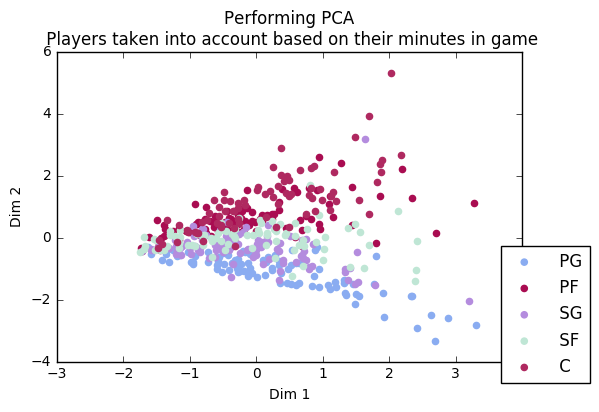

In [7]:
auxnames = ['REB','AST','TOV','STL','BLK','PF','PTS']
df_final = df_numVar[auxnames]

df_scaled = sk.preprocessing.scale(df_final)
pca = sk.decomposition.PCA(n_components=2, whiten=True)
df_red = pca.fit_transform(df_scaled)

statesN = [1,2,3,4,5]
states = [invdict[x] for x in statesN]
states

import matplotlib.patches as mpatches
pylab.title("Performing PCA\n Players taken into account based on their minutes in game")
pylab.xlabel("Dim 1")
pylab.ylabel("Dim 2")
#pylab.scatter(df_red[:, 0], df_red[:, 1], c=position_labels)

states = [invdict[x] for x in [1,2,3,4,5]]
for i,l in enumerate(states):
    x = []
    y = []
    for j,_ in enumerate(df_red[:, 0]):
        if position_labels[j] == i+1:
            x.append(df_red[j,0])
            y.append(df_red[j,1])
    pylab.scatter(x,y,label=l,color = np.random.rand(3,1) )

pylab.legend(loc='upper center', bbox_to_anchor=(1.05, .4) ,scatterpoints = 1)
pylab.show()

In [15]:
df_withsvds = np.append(df_final, df_red, axis=1)

Using keplermapper

In [20]:
# Initialize
#mapper = km.KeplerMapper(verbose=1)
mapper = KeplerMapper(verbose=1)

# Fit to and transform the data
projected_data = mapper.fit_transform(df_withsvds, projection=[7,8]) # filter column

# Create dictionary called 'complex' with nodes, edges and meta-information
complex = mapper.map(projected_data, df_withsvds[:,:7], nr_cubes=25)

# Visualize it
mapper.visualize(complex, path_html="NBA_keplermapper_svds_output.html", 
                 title="Mapper_on_NBA_data")


..Projecting data using: [7, 8]

..Scaling with: MinMaxScaler(copy=True, feature_range=(0, 1))

Mapping on data shaped (476L, 2L) using dimensions

Creating 15625 hypercubes.

created 0 edges and 5 nodes in 0:00:00.427000.

Wrote d3.js graph to 'NBA_keplermapper_svds_output.html'
